In [165]:
import numpy as np
import random
import torch
import torch.nn as nn            
import torch.optim as optim      
import torch.nn.functional as F  
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from time import time
from matplotlib import rc

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#number of epoch:
epoch = 3

In [166]:
class MNIST(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.png'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            self.images.append(image.copy())
            # avoid too many opened files bug
            image.close()
            self.labels.append(label)

    # probably the most important to customize.
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [167]:
# Load the training set:
trainset = MNIST(
    root='mnist_png/training',
    preload=True, transform=transforms.ToTensor(),
)

trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# Load the testset:
testset = MNIST(
    root='mnist_png/testing',
    preload=True, transform=transforms.ToTensor(),
)

testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [168]:
class NetSeq(nn.Module):
    def __init__(self):
        super(NetSeq, self).__init__()

        #set seed
        random.seed(100)
        torch.manual_seed(100)

        # conv layers: feature extractor
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            #nn.Dropout2d(),
            nn.MaxPool2d(2),
            nn.ReLU()
        )

        # fc layers: classifier
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 300),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(300, 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [169]:
#define a function to compute average loss and accuracy rate
def result_hinge(loader):
    model.eval()
    sum_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            sum_loss += nn.MultiMarginLoss(p=2,reduction='sum')(output, target).item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    return (sum_loss/len(loader.dataset)), (100. * correct / len(loader.dataset)), correct, len(loader.dataset) 

In [173]:
drop_out_params = np.linspace(0, 1, num=10, endpoint= False)

In [174]:
drop_out_params

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# squared hinge loss with dropout

In [195]:
#define the hinge loss function
def square_hinge_loss(output, target):
    output_y = output[torch.arange(0,target.size(0)).long(), target.data].view(-1,1)
    loss = output - output_y + 1
    loss[torch.arange(0, target.size(0)).long(), target.data] = 0
    loss[loss<0]=0
    
    return torch.sum(loss**2)

In [196]:
#create an array of regularization parameters from 0 to 0.03 with step size 0.001
reg_params = np.linspace(0, 0.03, num=31, endpoint=True)

#initiate a list storing training average loss for different reg_param
train_ave_loss_L1 = []

#initiate a list storing test average loss for different reg_param
test_ave_loss_L1 = []

#initiate a list storing training accuracy for different reg_param
train_acc_L1 = []

#initiate a list storing test accuracy for different reg_param
test_acc_L1 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_L1 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_L1 = []

In [197]:
#for reg_param in reg_params:
for drop_out in drop_out_params:
    class NetSeq(nn.Module):
        def __init__(self):
            super(NetSeq, self).__init__()

            #set seed
            random.seed(100)
            torch.manual_seed(100)

            # conv layers: feature extractor
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=5),
                #nn.Dropout2d(),
                nn.MaxPool2d(2),
                nn.ReLU()
            )

            # fc layers: classifier
            self.fc_layers = nn.Sequential(
                nn.Linear(320, 300),
                nn.ReLU(),
                nn.Dropout(p=drop_out),
                nn.Linear(300, 10),
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)
            x = self.fc_layers(x)
            return x

    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)

            #forward pass
            output = model(data)

            #compute the L1 norm of weight matrix on the last layer 
            #l1_norm = torch.norm(model.fc_layers[-1].weight, p=1)

            #compute loss
            loss = square_hinge_loss(output, target)/target.size(0)
            a_list.append(loss.item())

            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    drop_out, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))

    result_train = result_hinge(trainset_loader)
    result_test = result_hinge(testset_loader)
    train_ave_loss_L1.append(result_train[0])
    test_ave_loss_L1.append(result_test[0])
    train_acc_L1.append(result_train[1])
    test_acc_L1.append(result_test[1])
    matrix_norm_L1.append(np.linalg.norm(model.fc_layers[-1].weight.detach().numpy()))
    listoflist_L1.append(list(a_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))
    print('train_ave_loss_L1',train_ave_loss_L1)


Regularization parameter: 0.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 8.931667
Regularization parameter: 0.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.592236
Regularization parameter: 0.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.539611
Regularization parameter: 0.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.325542
Regularization parameter: 0.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.073478
Regularization parameter: 0.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.317288
Regularization parameter: 0.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.376682
Regularization parameter: 0.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.169009
Regularization parameter: 0.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.027529
Regularization parameter: 0.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.124372
28.59s
Regularization parameter: 0.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.089459
Regularization parameter: 0.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.221514
Regularization pa

Regularization parameter: 0.300 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.167830
28.20s
Regularization parameter: 0.300 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.131235
Regularization parameter: 0.300 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.264287
Regularization parameter: 0.300 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.176711
Regularization parameter: 0.300 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.186952
Regularization parameter: 0.300 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.105430
Regularization parameter: 0.300 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.115403
Regularization parameter: 0.300 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.030280
Regularization parameter: 0.300 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.165466
Regularization parameter: 0.300 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.094241
27.47s
Regularization parameter: 0.300 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.068163
Regularization parameter: 0.300 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.294185
Regular

Regularization parameter: 0.600 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.204471
Regularization parameter: 0.600 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.129133
Regularization parameter: 0.600 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.307573
Regularization parameter: 0.600 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.133600
25.23s
Regularization parameter: 0.600 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.056517
Regularization parameter: 0.600 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.271587
Regularization parameter: 0.600 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.044001
Regularization parameter: 0.600 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.387677
Regularization parameter: 0.600 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.155357
Regularization parameter: 0.600 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.085497
Regularization parameter: 0.600 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.244852
Regularization parameter: 0.600 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.457644
Regularizati

28.77s
Regularization parameter: 0.900 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.246926
Regularization parameter: 0.900 Train Epoch: 3 [7936/60000 (13%)]	Loss: 1.195447
Regularization parameter: 0.900 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.212947
Regularization parameter: 0.900 Train Epoch: 3 [20736/60000 (35%)]	Loss: 1.601816
Regularization parameter: 0.900 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.711431
Regularization parameter: 0.900 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.408053
Regularization parameter: 0.900 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.696166
Regularization parameter: 0.900 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.954337
Regularization parameter: 0.900 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.789081
Regularization parameter: 0.900 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.837152
27.53s

Test set: Average loss: 0.0121, Accuracy: 9736/10000 (97%)

train_ave_loss_L1 [0.008761819071485662, 0.008103544110199437, 0.008300126337407468, 0.00853859599428688, 0.

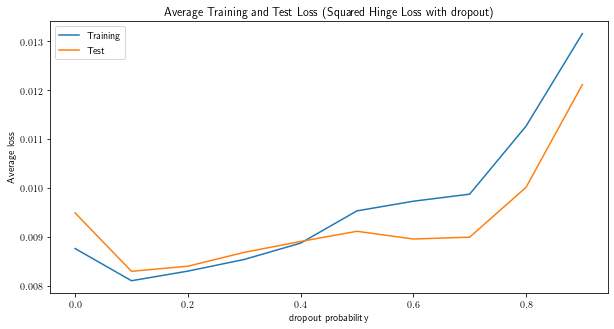

In [204]:
plt.rc('text', usetex=True)
#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Average Training and Test Loss (Squared Hinge Loss with "
  r"dropout)")
plt.plot(drop_out_params, train_ave_loss_L1, label="Training")
plt.plot(drop_out_params, test_ave_loss_L1, label="Test")
plt.xlabel("dropout probability")
plt.ylabel("Average loss")
plt.legend()
plt.show()

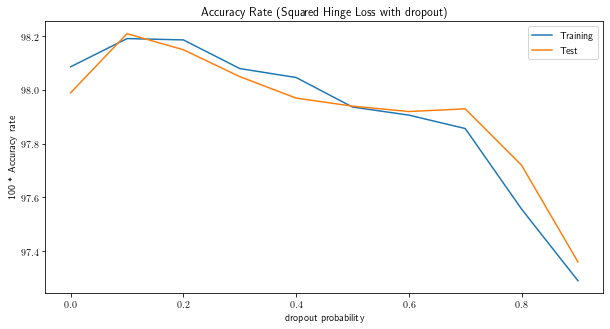

In [199]:
plt.rc('text', usetex=True)

#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Accuracy Rate  (Squared Hinge Loss with "
  r"dropout)")
plt.plot(drop_out_params, train_acc_L1, label="Training")
plt.plot(drop_out_params, test_acc_L1, label="Test")
plt.xlabel("dropout probability")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

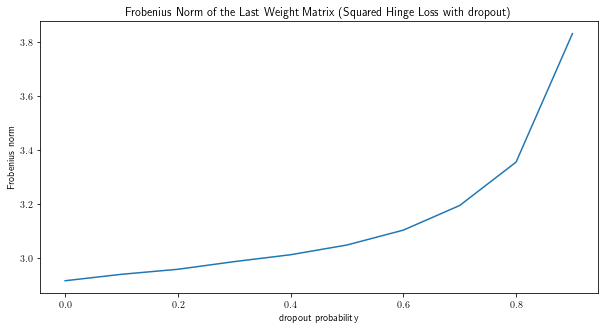

In [200]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Frobenius Norm of the Last Weight Matrix (Squared Hinge Loss with dropout)"
    )
plt.plot(drop_out_params, matrix_norm_L1)
plt.xlabel("dropout probability")
plt.ylabel("Frobenius norm")
plt.show()

# Softmax + MSE loss with dropout

In [205]:
epoch = 3
#create an array of regularization parameters from 0 to 0.03 with step size 0.001
reg_params = np.linspace(0, 0.03, num=31, endpoint=True)

#initiate a list storing training average loss for different reg_param
train_ave_loss_MSE_L1= []

#initiate a list storing test average loss for different reg_param
test_ave_loss_MSE_L1 = []

#initiate a list storing training accuracy for different reg_param
train_acc_MSE_L1 = []

#initiate a list storing test accuracy for different reg_param
test_acc_MSE_L1 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_MSE_L1 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_L1 = []

In [206]:
for drop_out in drop_out_params:
    class NetSeq(nn.Module):
        def __init__(self):
            super(NetSeq, self).__init__()

            #set seed
            random.seed(100)
            torch.manual_seed(100)

            # conv layers: feature extractor
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=5),
                #nn.Dropout2d(),
                nn.MaxPool2d(2),
                nn.ReLU()
            )

            # fc layers: classifier
            self.fc_layers = nn.Sequential(
                nn.Linear(320, 300),
                nn.ReLU(),
                nn.Dropout(p=drop_out),
                nn.Linear(300, 10),
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)
            x = self.fc_layers(x)
            return x
    
    
    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute the L1 norm of weight matrix on the last layer 
            #l1_norm = torch.norm(model.fc_layers[-1].weight, p=1)
            
            #softmax for MSE
            m = nn.Softmax(dim=1)
            output_softmax = m(output)
            target_onehot = torch.FloatTensor(target.size()[0], output.size()[1])
            target_onehot.zero_()
            target_onehot.scatter_(1, target.view(-1,1), 1)

#             print('output_softmax', output_softmax.size())
#             print('target_onehot', target_onehot.size())
            
            #compute loss
            loss_f = torch.nn.MSELoss(reduce=True, size_average=True)
            loss = loss_f(output_softmax, target_onehot)

            a_list.append(loss.item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    drop_out, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_hinge(trainset_loader)
    result_test = result_hinge(testset_loader)
    train_ave_loss_MSE_L1.append(result_train[0])
    test_ave_loss_MSE_L1.append(result_test[0])
    train_acc_MSE_L1.append(result_train[1])
    test_acc_MSE_L1.append(result_test[1])
    matrix_norm_MSE_L1.append(np.linalg.norm(model.fc_layers[-1].weight.detach().numpy()))
    listoflist_L1.append(list(a_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

/Users/duanjingyi/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Regularization parameter: 0.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 0.089910
Regularization parameter: 0.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.089970
Regularization parameter: 0.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.089973
Regularization parameter: 0.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.090052
Regularization parameter: 0.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.089784
Regularization parameter: 0.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.089953
Regularization parameter: 0.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.089921
Regularization parameter: 0.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.089669
Regularization parameter: 0.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.089831
Regularization parameter: 0.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.089599
26.51s
Regularization parameter: 0.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.089430
Regularization parameter: 0.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.089487
Regularization pa

Regularization parameter: 0.300 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.089504
Regularization parameter: 0.300 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.089321
Regularization parameter: 0.300 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.089196
Regularization parameter: 0.300 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.088926
Regularization parameter: 0.300 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.088594
Regularization parameter: 0.300 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.088528
Regularization parameter: 0.300 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.088408
Regularization parameter: 0.300 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.087303
25.45s
Regularization parameter: 0.300 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.087165
Regularization parameter: 0.300 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.084668
Regularization parameter: 0.300 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.081101
Regularization parameter: 0.300 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.076073
Regularizati

Regularization parameter: 0.600 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.081190
Regularization parameter: 0.600 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.073335
Regularization parameter: 0.600 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.065785
Regularization parameter: 0.600 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.062865
Regularization parameter: 0.600 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.048349
Regularization parameter: 0.600 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.044724
Regularization parameter: 0.600 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.033197
24.96s

Test set: Average loss: 0.1504, Accuracy: 8626/10000 (86%)

Regularization parameter: 0.700 Train Epoch: 1 [0/60000 (0%)]	Loss: 0.089857
Regularization parameter: 0.700 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.089976
Regularization parameter: 0.700 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.089970
Regularization parameter: 0.700 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.090154
Regularization parameter: 0.700 Trai

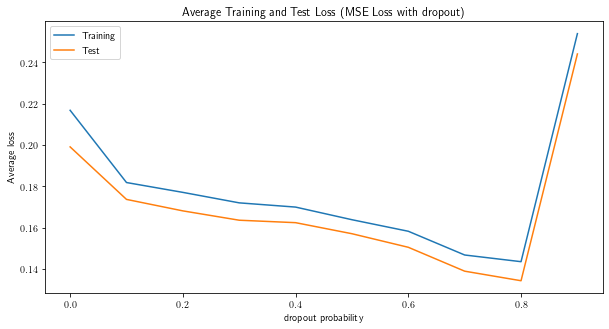

In [207]:
plt.rc('text', usetex=True)
#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Average Training and Test Loss (MSE Loss with "
  r"dropout)")
plt.plot(drop_out_params, train_ave_loss_MSE_L1, label="Training")
plt.plot(drop_out_params, test_ave_loss_MSE_L1, label="Test")
plt.xlabel("dropout probability")
plt.ylabel("Average loss")
plt.legend()
plt.show()

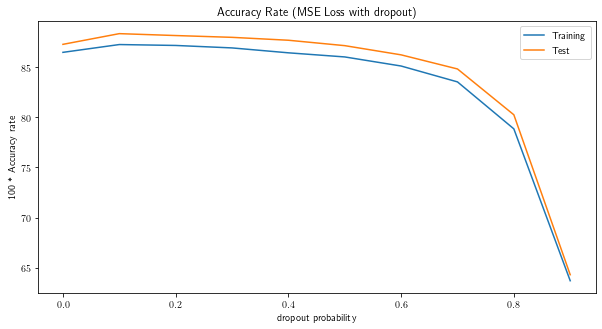

In [208]:
plt.rc('text', usetex=True)

#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Accuracy Rate (MSE Loss with "
          r"dropout) "
          )
plt.plot(drop_out_params, train_acc_MSE_L1, label="Training")
plt.plot(drop_out_params, test_acc_MSE_L1, label="Test")
plt.xlabel("dropout probability")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

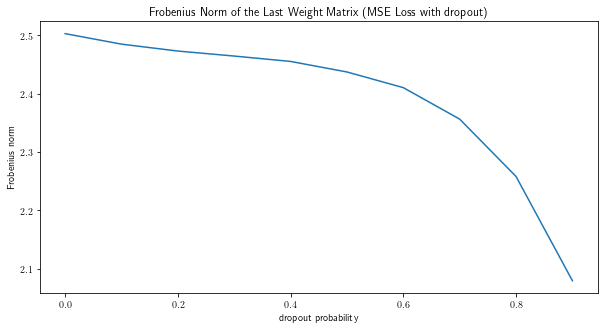

In [209]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Frobenius Norm of the Last Weight Matrix (MSE Loss with "
  r"dropout)")
plt.plot(drop_out_params, matrix_norm_MSE_L1)
plt.xlabel("dropout probability")
plt.ylabel("Frobenius norm")
plt.show()